In [1]:
import sys, os
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
import mdtraj as md

import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')
from MSMAnalysis import *
from funcs_db_assign import *
from funcs_featurise import *

In [2]:
protein = 'egfr'
all_features = ['distgroup', 'dihedgroup']
base_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/')

In [3]:
MA = MSMAnalysis(protein, trajlen_cutoff=1000)
MA.load_ftrajs(names=all_features, arc_dir=base_path/'data'/f'{protein}'/'ftrajs')

crystal_files = natsorted([str(f) for f in Path(f"/arc/human_{protein}/").glob("kinoml*.pdb")])
frames = [] 
for crystal in crystal_files:
    sample_frame = md.load(crystal)
    sample_frame = sample_frame.atom_slice(sample_frame.top.select('mass>1.1'))
    frames.append(sample_frame)
crystals = md.join(frames)
crystals = crystals.superpose(crystals, 0)

featurisers = [dbdist_featuriser, dbdihed_featuriser]
c_ftrajs_dict = {f.__name__.split('_')[0]:[f(traj=crystals, protein=protein)] for f in featurisers}
MA.load_data(data_key='crystal', ftraj_dict=c_ftrajs_dict)
c_ftrajs, _ = prepare_ftrajs(MA.data['crystal'], stride=1, len_cutoff=1)

Loading feature:  distgroup


100%|██████████| 3472/3472 [00:20<00:00, 168.43it/s]


Loading feature:  dihedgroup


100%|██████████| 3472/3472 [00:21<00:00, 163.07it/s]


Features loaded: {'dihedgroup', 'distgroup'}


/home/rzhu/Desktop/projects/kinase_analysis/src/MSMAnalysis.py:126: UserWarning: Data feature dbdist not found in the loaded feature trajectories to build MSM.
  warnings.warn(f'Data feature {key} not found in the loaded feature trajectories to build MSM.', UserWarning)
/home/rzhu/Desktop/projects/kinase_analysis/src/MSMAnalysis.py:126: UserWarning: Data feature dbdihed not found in the loaded feature trajectories to build MSM.
  warnings.warn(f'Data feature {key} not found in the loaded feature trajectories to build MSM.', UserWarning)


Preparing feature trajectories...


100%|██████████| 1/1 [00:00<00:00, 11586.48it/s]


In [4]:
sim_dihed_assignments = np.concatenate(MA.select_ftrajs(features=['dihedgroup'])['dihedgroup'])
sim_dist_assignments = np.concatenate(MA.select_ftrajs(features=['distgroup'])['distgroup'])
sim_spatial_counts, sim_dihed_counts = dunbrack_count(sim_dist_assignments, sim_dihed_assignments)

In [5]:
c_dbdists = MA.select_ftrajs(features=['dbdist'], data_key='crystal')['dbdist']
c_dbdist_cat = np.concatenate(c_dbdists)
c_dbdiheds = MA.select_ftrajs(features=['dbdihed'], data_key='crystal')['dbdihed']
c_dbdihed_cat = np.concatenate(c_dbdiheds)

In [6]:
crystal_spatial_assignments, crystal_dihed_assignments = dfg_featuriser(dists=c_dbdist_cat, diheds=c_dbdihed_cat[:,[0,1,2,3,4,5,8]], 
                                                                      dist_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_spatial_centroids.npy', allow_pickle=True), 
                                                                      dihed_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_dihed_centroids.npy', allow_pickle=True).item(), 
                                                                      dihed_cutoff=1.5)
crystal_spatial_counts, crystal_dihed_counts = dunbrack_count(crystal_spatial_assignments, crystal_dihed_assignments)

In [7]:
sim_diheds = [np.sum([i[0] for i in sim_dihed_counts])] + sim_dihed_counts[0][1:] + sim_dihed_counts[1][1:] + sim_dihed_counts[2][1:]
crystal_diheds = [np.sum([i[0] for i in crystal_dihed_counts])] + crystal_dihed_counts[0][1:] + crystal_dihed_counts[1][1:] + crystal_dihed_counts[2][1:]

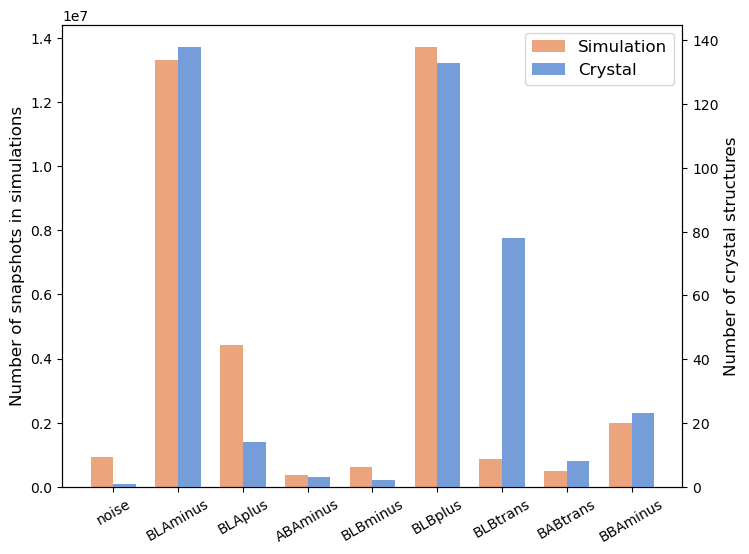

In [10]:
dihed_cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']

ind = np.arange(9)
width = 0.35

fig, ax1 = plt.subplots(figsize=(8, 6))
bars1 = ax1.bar(ind - width/2, sim_diheds, width, label='Simulation', color=(236/255, 164/255, 124/255))
ax1.set_ylabel('Number of snapshots in simulations', fontsize=12)
#ax1.set_yscale('log')

ax2 = ax1.twinx()
bars2 = ax2.bar(ind + width/2, crystal_diheds, width, label='Crystal', color=(117/255, 157/255, 218/255))
ax2.set_ylabel('Number of crystal structures', fontsize=12)
#ax2.set_yscale('linear')

ax1.set_xticks(ind)
ax1.set_xticklabels(dihed_cluster_labels, rotation=30)

bars_1, labels_1 = ax1.get_legend_handles_labels()
bars_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(bars_1 + bars_2, labels_1 + labels_2, loc='upper right', fontsize=12, markerscale=4)

plt.savefig(f'/home/rzhu/Desktop/projects/kinase_analysis/data/{protein}/plots/simulation_vs_crystal_count.png',
             transparent=True, bbox_inches='tight', dpi=300)
plt.show()